In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
#import seaborn as sns
#from scipy.stats import ks_2samp
#import glob
#import time
import requests
import bs4
#import lxml
import altair as alt
import folium
import geopandas as gdp
import math
import json
import langdetect as land
#from mpl_toolkits import mplot3d
import plotly
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings

Import data

In [2]:
tweet = pd.read_excel(os.path.join('Twitter+data+in+sheets.xlsx'), 'Tweet')
loca = pd.read_excel(os.path.join('Twitter+data+in+sheets.xlsx'), 'Location')
user = pd.read_excel(os.path.join('Twitter+data+in+sheets.xlsx'), 'User')




KeyboardInterrupt: 

data processing

In [ ]:
tweet = tweet.rename(str.strip,axis = 1)
loca = loca.rename(str.strip,axis = 1)
user = user.rename(str.strip,axis = 1)
merged = tweet.merge(user, left_on = 'UserID', right_on = 'UserID', how = 'left').merge(loca, left_on = 'LocationID',right_on = 'LocationID')
eng = merged[merged['Lang'] == 'en']
eng['length'] = eng['text'].str.len()
warnings.filterwarnings('ignore')
notloc = eng.drop(columns = ['Country','State','StateCode','City','LocationID']).dropna()
eng.head()

In [ ]:
notloc['time inteval'] = notloc["Hour"].apply(
    lambda x: "Early morning" if (x >=6 and x < 9) 
    else "Late morning" if (x >= 9 and x < 12) 
    else "Noon" if (x >= 12 and x < 15) 
    else "Afternoon" if (x >= 15 and x < 18) 
    else "Evening" if (x >= 18 and x < 21) 
    else "Early night" if (x >= 21 and x < 24)
    else 'Late night')



In [ ]:
notloc['Reach'] = notloc['Reach'].apply(lambda x: 1 if x==0 else x)

### Since a lot of us are Econ students, let's use our tool——Stata!!!

In [ ]:
with pd.ExcelWriter(os.path.join('Stata reg.xlsx'), engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    s = notloc[['Weekday',
        'IsReshare','Reach','RetweetCount','Likes','Klout','Sentiment',
        'Gender','time inteval','length']]
    s.to_excel(writer, 'sheet1', index = False, header = True)


In [ ]:
#notloc[notloc['Gender'] == 'Unknown']

In [ ]:
stata = pd.read_stata('stata_out.dta')
#stata['root_reach'] = stata['Reach'].apply(lambda x:x**(3/4))
counted = stata['timeinteval'].value_counts()
stata['time_weighted_count'] = stata['timeinteval'].apply(lambda x:1/counted[x])
stata.head()


In [ ]:
brush = alt.selection(type='interval')
stata_s = stata.sample(2000)
points = alt.Chart(stata_s).mark_point().encode(
    x='length:Q',
    y='log_reach:Q',
    color=alt.condition(brush, 'timeinteval:N', alt.value('lightgray'))
).add_selection(
    brush
).properties(
    width=650,
    height=560
)

bars = alt.Chart(stata_s).mark_bar().encode(
    y='timeinteval:N',
    color='timeinteval:N',
    x='sum(time_weighted_count):Q'
).transform_filter(
    brush
)

points & bars


### Frisch-Waugh Regress

In [ ]:
stata

In [38]:
#Early_morning----log_reach
#ignore Early_night, Weekdaydummy7, Genderdummy4

plot_df = pd.DataFrame()
lr = LinearRegression()
lr1 = LinearRegression()
lr2 = LinearRegression()
X = stata[['length','Sentiment', 'Weekdaydummy1','Weekdaydummy2',
                      'Weekdaydummy3','Weekdaydummy4','Weekdaydummy5','Weekdaydummy6',
                      'Genderdummy1','Genderdummy2','Genderdummy3',
           'Late_night', 'Evening' ,'Late_morning','Afternoon','Noon']]
lr.fit(X=X, y=stata['Early_morning'])
re = lr.predict(X) - stata['Early_morning']

lr1.fit(X=X, y = stata['log_reach'])
re1 = lr1.predict(X) - stata['log_reach']

lr2.fit(X=pd.DataFrame(re), y=re1)
print(lr2.coef_)
print(lr2.intercept_)
plot_df['re'] = re
plot_df['re1'] = re1
plot_df['category'] = 'e_m'


#Late_morning----log_reach
#ignore Early_night, Weekdaydummy7, Genderdummy4

plot_df1 = pd.DataFrame()
lr = LinearRegression()
lr1 = LinearRegression()
lr2 = LinearRegression()
X = stata[['length','Sentiment', 'Weekdaydummy1','Weekdaydummy2',
                      'Weekdaydummy3','Weekdaydummy4','Weekdaydummy5','Weekdaydummy6',
                      'Genderdummy1','Genderdummy2','Genderdummy3',
           'Late_night', 'Evening' ,'Afternoon','Noon','Early_morning']]
lr.fit(X=X, y=stata['Late_morning'])
re = lr.predict(X) - stata['Late_morning']

lr1.fit(X=X, y = stata['log_reach'])
re1 = lr1.predict(X) - stata['log_reach']

lr2.fit(X=pd.DataFrame(re), y=re1)
print(lr2.coef_)
print(lr2.intercept_)
plot_df1['re'] = re
plot_df1['re1'] = re1
plot_df1['category'] = 'l_m'

#Noon----log_reach
#ignore Early_night, Weekdaydummy7, Genderdummy4

plot_df2 = pd.DataFrame()
lr = LinearRegression()
lr1 = LinearRegression()
lr2 = LinearRegression()
X = stata[['length','Sentiment', 'Weekdaydummy1','Weekdaydummy2',
                      'Weekdaydummy3','Weekdaydummy4','Weekdaydummy5','Weekdaydummy6',
                      'Genderdummy1','Genderdummy2','Genderdummy3',
           'Late_night', 'Evening' ,'Afternoon','Early_morning','Late_morning']]
lr.fit(X=X, y=stata['Noon'])
re = lr.predict(X) - stata['Noon']

lr1.fit(X=X, y = stata['log_reach'])
re1 = lr1.predict(X) - stata['log_reach']

lr2.fit(X=pd.DataFrame(re), y=re1)
print(lr2.coef_)
print(lr2.intercept_)
plot_df2['re'] = re
plot_df2['re1'] = re1
plot_df2['category'] = 'N'



p = pd.concat([plot_df,plot_df1,plot_df2])
p
#sns.lmplot(data=plot_df, x='re', y='re1');


[0.33538509]
-3.5005476063584735e-16
[0.42431259]
1.0655422088210259e-16
[0.42209329]
3.491961444243836e-18


,re,re1,category
0,-0.010139,2.259716,e_m
1,0.000857,-0.219732,e_m
2,-0.037015,1.801095,e_m
3,-0.009555,2.013650,e_m
4,0.640897,-0.277535,e_m
...,...,...,...
93558,-0.012017,1.334007,N
93559,-0.012064,1.409764,N
93560,-0.003375,1.341372,N
93561,0.003994,0.372015,N


In [ ]:
#Early_morning----log_reach
#ignore Early_night, Weekdaydummy7, Genderdummy4
def inter(vari = 'Early_morning'):
    lis = ['length','Sentiment', 'Weekdaydummy1','Weekdaydummy2',
            'Weekdaydummy3','Weekdaydummy4','Weekdaydummy5','Weekdaydummy6',
             'Genderdummy1','Genderdummy2','Genderdummy3',
               'Late_night', 'Evening' ,'Late_morning','Afternoon','Noon','Early_morning']
    lis.remove(vari)
    plot_df = pd.DataFrame()
    lr = LinearRegression()
    lr1 = LinearRegression()
    lr2 = LinearRegression()
    X = stata[lis]
    lr.fit(X=X, y=stata[vari])
    re = lr.predict(X) - stata[vari]

    lr1.fit(X=X, y = stata['log_reach'])
    re1 = lr1.predict(X) - stata['log_reach']

    lr2.fit(X=pd.DataFrame(re), y=re1)
    plot_df['re'] = re
    plot_df['re1'] = re1
    sns.lmplot('re', 're1', data=plot_df)
    return 'coefficient = '+ str(lr2.coef_)
    #plot_df['category'] = 'e_m'


In [ ]:
warnings.filterwarnings('ignore')
interact(inter, x = ['Late_night', 'Evening' ,'Late_morning','Afternoon','Noon','Early_morning']);
#['Late_night', 'Evening' ,'Late_morning','Afternoon','Noon','Early_morning']
warnings.filterwarnings('default')

In [ ]:
tips

/Users/pro/opt/anaconda3/envs/dsc80/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/pro/opt/anaconda3/envs/dsc80/lib/python3.8/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


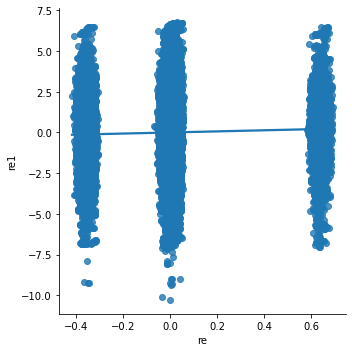

In [57]:
seaborn_grid = sns.lmplot('re', 're1', data=plot_df, sharey = True)



In [ ]:
'''
rename timedummy1 Afternoon
	rename timedummy7 Noon
	rename (timedummy2) (Early_morning)
	rename (timedummy3) (Early_night)
	rename timedummy4 Evening
	rename (timedummy5) (Late_morning)
	rename (timedummy6) (Late_night)'''

In [ ]:
lr1.fit(X=X, y = stata['log_reach'])
re1 = lr1.predict(X) - stata['log_reach']
re1

#### What is Klout?
Klout used Bing, Facebook, Foursquare, Google+, Instagram, LinkedIn Twitter, Wikipedia, and YouTube data to create Klout user profiles that were assigned a unique "Klout Score". Klout scores ranged from 1 to 100, with higher scores corresponding to a higher ranking of the breadth and strength of one's online social influence. <br>
Klout measured influence by using data points from Twitter, such as the following count, follower count, retweets, list memberships, how many spam/dead accounts were following you, how influential the people who retweet you were and unique mentions.
#### What is reach?
Tweet reach is the number of people who see your tweet.

In [ ]:
land.detect('AWS Technical Customer Service Associate for http://www.amazon.com/ (Seattle WA) https://us-amazon.icims.com/jobs/382628/aws-technical-customer-service-associate/job')